In [1]:
import pathlib
import numpy as np

import matplotlib.pyplot as plt

import torch
from torch import nn

import datasets
from transformers import AutoTokenizer

import umap

In [2]:
dataset = datasets.load_dataset('bookcorpus')['train']
dataset[:3]

/home/adam/miniconda3/envs/lima/lib/python3.12/site-packages/datasets/load.py:1461: FutureWarning: The repository for bookcorpus contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/bookcorpus
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


{'text': ['usually , he would be tearing around the living room , playing with his toys .',
  'but just one look at a minion sent him practically catatonic .',
  "that had been megan 's plan when she got him dressed earlier ."]}

In [3]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [206]:
import numpy as np
import torch
import torch.nn as nn

class Absolute_attention(nn.Module):
  def __init__(self, dim=256, num_heads=16, hidden_dim=None, time_dim=64):
    super().__init__()

    self.dim = dim
    self.num_heads = num_heads
    self.time_dim = time_dim

    if isinstance(hidden_dim, int):
      self.hidden_dim = hidden_dim
    else:
      assert dim % num_heads == 0
      self.hidden_dim = dim // num_heads

    # assert self.hidden_dim % 2 == 0
    # self.time_embedding = time_embedding
    self.time_angle = nn.Parameter(torch.rand(self.num_heads, self.time_dim))
    self.head_time_delta = nn.Parameter(torch.rand(self.num_heads))

    self.Q = nn.Linear(dim, num_heads * (self.hidden_dim + 1))
    self.K = nn.Linear(dim, num_heads * self.hidden_dim)
    self.V = nn.Linear(dim, num_heads * self.hidden_dim)
    self.O = nn.Linear(num_heads * self.hidden_dim, dim)

    with torch.no_grad():
      self.Q.bias.copy_(torch.zeros_like(self.Q.bias))
      self.K.bias.copy_(torch.zeros_like(self.K.bias))
      self.V.bias.copy_(torch.zeros_like(self.V.bias))
      self.O.bias.copy_(torch.zeros_like(self.O.bias))

    self.dropout = nn.Dropout(p=0.5)

  def forward(self, tensor, attention_mask):
    batch_length = tensor.shape[:2]
    # print(f'{tensor.shape=}')
    q = self.Q(tensor).view(*batch_length, self.num_heads, self.hidden_dim + 1)
    # q = (q + attention_mask[..., None, None])
    q = q.softmax(dim=-1)

    time_angles = (torch.arange(batch_length[1]).to(self.head_time_delta.device)[:, None, None]
                   + self.head_time_delta[None, :, None]) * self.time_angle  # shape: [length, num_heads, dim_time] ?
    cosines, sines = time_angles.cos(), time_angles.sin()
    time = torch.cat([cosines + sines, cosines - sines], dim=-1) / np.sqrt(self.hidden_dim)  # shape: [length, num_heads, 2*dim_time] ?
    q = q[..., :-1, None].sum(-2) * time
    # q shape: [batch_size, length, num_heads, 2*dim_time] = [batch_size, length, 1, 1] * [length, num_heads, 2*dim_time] ?

    k = self.K(tensor).view(*batch_length, self.num_heads, self.hidden_dim)  # bthd
    k = k.softmax(dim=-1) * attention_mask[..., None, None]

    k_time_angles = torch.arange(batch_length[1]).to(self.time_angle.device)[:, None, None] * self.time_angle
    k_cosines, k_sines = time_angles.cos(), time_angles.sin()
    k_time = torch.cat([k_cosines + k_sines, k_cosines - k_sines], dim=-1) / np.sqrt(self.hidden_dim)

    attention = torch.einsum('blhd,thd->blth', q, k_time)

    v = self.V(tensor).view(*batch_length, self.num_heads, self.hidden_dim)
    adding_comb = torch.einsum('blth,bthd->blhd', attention, v)

    output = self.O(adding_comb.reshape(*batch_length, self.dim))

    return self.dropout(output)

class Absolute_bert(nn.Module):
  def __init__(self, vocab_size, dim=256, num_heads=8, hidden_dim=None, depth=8, attention_type=Absolute_attention, dtype=torch.float):
    super().__init__()
    self.vocab_size = vocab_size
    self.dim = dim
    self.num_heads = num_heads
    self.hidden_dim = hidden_dim
    self.depth = depth

    self.embedding = nn.Embedding(vocab_size, dim, _weight=torch.nn.init.xavier_normal_(torch.ones([vocab_size, self.dim])))
    # self.embedding = nn.Embedding(vocab_size, dim, _weight=torch.rand(vocab_size, self.dim) / np.sqrt(self.dim))

    self.layers = nn.ModuleList([Absolute_attention(dim=dim,
      num_heads=num_heads,
      hidden_dim=hidden_dim
      ) for _ in range(depth)])
    self.dtype = dtype

  def forward(self, input_ids, attention_mask, **kwargs):
    # extended_attention_mask = attention_mask.to(dtype=self.dtype)  # fp16 compatibility
    # extended_attention_mask = (1.0 - extended_attention_mask) * torch.finfo(self.dtype).min

    tensor = self.embedding(input_ids)

    for layer in self.layers:
      output = layer(tensor, attention_mask)
      tensor = tensor + output

    return tensor

class Absolute_bert_for_masked_LM(nn.Module):
  def __init__(self, vocab_size, dim=256, num_heads=8, hidden_dim=None, depth=8, **kwargs):
    super().__init__()
    self.base_model = Absolute_bert(vocab_size, dim, num_heads, hidden_dim, depth, **kwargs)
    self.bias = nn.Parameter(torch.zeros(vocab_size))

  def forward(self, input_ids, attention_mask, labels=None, **kwargs):
    tensor = self.base_model(input_ids=input_ids, attention_mask=attention_mask, **kwargs)

    return tensor, labels

  def word_embeddings(self):
    return self.base_model.embedding.weight

subpath = '20240710.02:31:19' # sum_of_softmax
subpath = '20240710.18:31:50' # sum_of_softmax

In [212]:
import numpy as np
import torch
import torch.nn as nn

class Absolute_attention(nn.Module):
  def __init__(self, dim=256, num_heads=16, hidden_dim=None, time_dim=64):
    super().__init__()

    self.dim = dim
    self.num_heads = num_heads
    self.time_dim = time_dim

    if isinstance(hidden_dim, int):
      self.hidden_dim = hidden_dim
    else:
      assert dim % num_heads == 0
      self.hidden_dim = dim // num_heads

    # assert self.hidden_dim % 2 == 0
    # self.time_embedding = time_embedding
    self.time_angle = nn.Parameter(torch.rand(self.num_heads, self.time_dim))
    self.head_time_delta = nn.Parameter(torch.rand(self.num_heads))

    self.Q = nn.Linear(dim, num_heads * self.hidden_dim)
    self.K = nn.Linear(dim, num_heads * self.hidden_dim)
    self.V = nn.Linear(dim, num_heads * self.hidden_dim)
    self.O = nn.Linear(num_heads * self.hidden_dim, dim)

    with torch.no_grad():
      self.Q.bias.copy_(torch.zeros_like(self.Q.bias))
      self.K.bias.copy_(torch.zeros_like(self.K.bias))
      self.V.bias.copy_(torch.zeros_like(self.V.bias))
      self.O.bias.copy_(torch.zeros_like(self.O.bias))

    one = torch.zeros(self.dim)
    one[0] = 1
    self.one = nn.Parameter(one, requires_grad=False)
    self.b = nn.Parameter(torch.zeros(self.num_heads))
    
    self.dropout = nn.Dropout(p=0.5)

  def forward(self, tensor, attention_mask):
    batch_length = tensor.shape[:2]
    # print(f'{tensor.shape=}')
    q = self.Q(tensor).view(*batch_length, self.num_heads, self.hidden_dim)
    # q = (q + attention_mask[..., None, None])
    q0 = tensor @ self.one # shape: [batch_size, length]
    q0 = q0[..., None] + self.b
    q = torch.cat([q, q0[..., None].expand(-1, -1, -1, 1)], dim=-1)
    q = q.softmax(dim=-1)
    

    time_angles = (torch.arange(batch_length[1]).to(self.head_time_delta.device)[:, None, None]
                   + self.head_time_delta[None, :, None]) * self.time_angle  # shape: [length, num_heads, dim_time] ?
    cosines, sines = time_angles.cos(), time_angles.sin()
    time = torch.cat([cosines + sines, cosines - sines], dim=-1) / np.sqrt(self.hidden_dim)  # shape: [length, num_heads, 2*dim_time] ?
    q = q[..., :-1, None].sum(-2) * time
    # q shape: [batch_size, length, num_heads, 2*dim_time] = [batch_size, length, 1, 1] * [length, num_heads, 2*dim_time] ?

    k = self.K(tensor).view(*batch_length, self.num_heads, self.hidden_dim)  # bthd
    k = k.softmax(dim=-1) * attention_mask[..., None, None]

    k_time_angles = torch.arange(batch_length[1]).to(self.time_angle.device)[:, None, None] * self.time_angle
    k_cosines, k_sines = time_angles.cos(), time_angles.sin()
    k_time = torch.cat([k_cosines + k_sines, k_cosines - k_sines], dim=-1) / np.sqrt(self.hidden_dim)

    attention = torch.einsum('blhd,thd->blth', q, k_time)

    v = self.V(tensor).view(*batch_length, self.num_heads, self.hidden_dim)
    adding_comb = torch.einsum('blth,bthd->blhd', attention, v)

    output = self.O(adding_comb.reshape(*batch_length, self.dim))

    return self.dropout(output)

class Absolute_bert(nn.Module):
  def __init__(self, vocab_size, dim=256, num_heads=8, hidden_dim=None, depth=8, attention_type=Absolute_attention, dtype=torch.float):
    super().__init__()
    self.vocab_size = vocab_size
    self.dim = dim
    self.num_heads = num_heads
    self.hidden_dim = hidden_dim
    self.depth = depth

    self.embedding = nn.Embedding(vocab_size, dim, _weight=torch.nn.init.xavier_normal_(torch.ones([vocab_size, self.dim])))
    # self.embedding = nn.Embedding(vocab_size, dim, _weight=torch.rand(vocab_size, self.dim) / np.sqrt(self.dim))

    self.layers = nn.ModuleList([Absolute_attention(dim=dim,
      num_heads=num_heads,
      hidden_dim=hidden_dim
      ) for _ in range(depth)])
    self.dtype = dtype

  def forward(self, input_ids, attention_mask, **kwargs):
    # extended_attention_mask = attention_mask.to(dtype=self.dtype)  # fp16 compatibility
    # extended_attention_mask = (1.0 - extended_attention_mask) * torch.finfo(self.dtype).min

    tensor = self.embedding(input_ids)

    for layer in self.layers:
      output = layer(tensor, attention_mask)
      tensor = tensor + output

    return tensor

class Absolute_bert_for_masked_LM(nn.Module):
  def __init__(self, vocab_size, dim=256, num_heads=8, hidden_dim=None, depth=8, **kwargs):
    super().__init__()
    self.base_model = Absolute_bert(vocab_size, dim, num_heads, hidden_dim, depth, **kwargs)
    self.bias = nn.Parameter(torch.zeros(vocab_size))

  def forward(self, input_ids, attention_mask, labels=None, **kwargs):
    tensor = self.base_model(input_ids=input_ids, attention_mask=attention_mask, **kwargs)

    return tensor, labels

  def word_embeddings(self):
    return self.base_model.embedding.weight

# subpath = '20240710.03:33:50' # e1_as_pivot
subpath = '20240710.15:09:00' # e1_as_pivot

In [218]:
subpath = '20240704.20:55:54' # 4 abs_bert, bookcorpus
subpath = '20240704.21:19:36' # 5 abs_bert, wiki
# subpath = '20240704.21:26:11' # 6 abs_bert, bookcorpus, xavier_init_embedding
subpath = '20240704.21:33:23' # 7 abs_bert, wiki, xavier_init_embedding
# subpath = '20240709.10:26:55' # abs_architecture, lr 1e-5~1e-3, early exploded
subpath = '20240709.11:13:35' # abs_architecture, lr 1e-5~1e-3, exploded at 10000
subpath = '20240709.12:14:48' # time_attention, lr 1e-5~1e-3, exploded at before 6000

subpath = '20240710.23:13:03' # all1_as_pivot, mask_prob0.15

weight norms, min: 0.12710440158843994, max: 0.5519832968711853
min norms: ['[MASK]', '[PAD]', 'hounds', 'fares', 'amelie', 'sirens', 'dorian', 'hacking', 'saigon', 'laird']
max norms: ['to', '##s', ')', 'of', 'a', 'and', 'in', '.', 'the', ',']
bias norms, min: -0.016383593901991844, max: 0.03925391659140587
min norms: ['[PAD]', '[UNK]', '[MASK]', '##\\', '[unused653]', '[unused720]', 'ක', 'ᆼ', '##،', '[unused355]']
max norms: ['##s', 'japanese', ')', 'of', 'a', 'and', 'in', '.', 'the', ',']


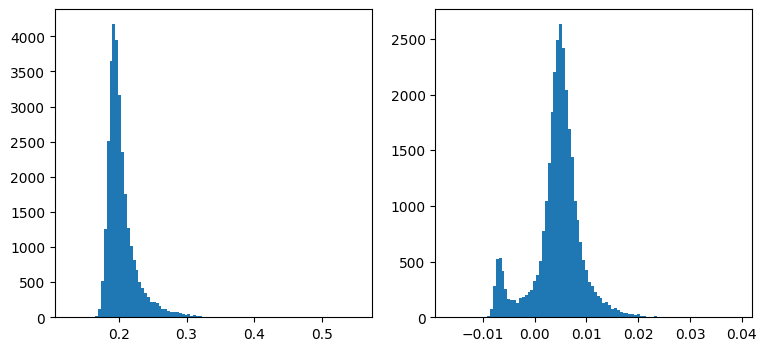

In [219]:
epoch_num = 0
batch_num = 30000


folder_path = pathlib.Path('data/limanet/')

model = torch.load(folder_path/subpath/f'epoch_{epoch_num}-batch_{batch_num}-model.pt', map_location='cpu')
word_reprs = model.word_embeddings().detach()

_, (ax_w, ax_b) = plt.subplots(1, 2, figsize=[9, 4])

# weight stats
norms = np.linalg.norm(word_reprs, axis=1)
indices = norms.argsort()
print(f"weight norms, min: {norms.min()}, max: {norms.max()}")
print("min norms:", tokenizer.convert_ids_to_tokens(indices[:10]))
print("max norms:", tokenizer.convert_ids_to_tokens(indices[-10:]))
_ = ax_w.hist(norms, bins=100)

# bias stats
biases = model.bias.detach()
indices = biases.argsort()
print(f"bias norms, min: {biases.min()}, max: {biases.max()}")
print("min norms:", tokenizer.convert_ids_to_tokens(indices[:10]))
print("max norms:", tokenizer.convert_ids_to_tokens(indices[-10:]))
if hasattr(model, 'predictor') and hasattr(model.predictor, 'base_vec'):
  print(f"base vec norm: {model.predictor.base_vec.norm()}")
_ = ax_b.hist(biases, bins=100)

In [220]:
sentence = ['I love to [MASK].', 'Hi, how are [MASK]?']
inputs = tokenizer(sentence, return_tensors='pt', padding=True, add_special_tokens=False)
inputs

res = model(**inputs)[0]

In [221]:
ids = tokenizer.encode(sentence, add_special_tokens=False)
mask_pos = np.where([(id_ == tokenizer.vocab['[MASK]']) for id_ in ids])[0]
tokenizer.convert_ids_to_tokens(ids), mask_pos

(['i', 'love', 'to', '[MASK]', '.', 'hi', ',', 'how', 'are', '[MASK]', '?'],
 array([3, 9]))

In [222]:
n_tops = 10

score = res @ word_reprs.T
preds = score.argsort(dim=2).flip(2)[:, :, :n_tops]

In [223]:
for truth_ids, sample in zip(inputs['input_ids'], preds):
  truth_tokens = tokenizer.convert_ids_to_tokens(truth_ids)
  max_length = max([len(token) for token in truth_tokens])
  
  for token, candidates in zip(truth_tokens, sample):
    print(token.ljust(max_length), tokenizer.convert_ids_to_tokens(candidates))
  print()

i      ['be', 'know', 'according', 'what', 'to', 'want', 'back', 'due', 'decided', 'moved']
love   ['refer', 'according', 'be', 'what', 'make', 'due', 'want', 't', 'get', 'returned']
to     ['according', 'make', 'due', 'refer', 'want', 'be', 'addition', 'wanted', 'you', 'know']
[MASK] ['according', 'refer', 'due', 'be', 'referred', 'addition', 'able', 'moved', 'prior', 'went']
.      ['according', 'refer', 'addition', 'able', 'prior', '2011', 'due', '2007', 'referred', 'participate']
[PAD]  ['2019', '2010', '2007', '2014', '2011', '2012', '2001', '6', '2020', '2008']

hi     ['##fera', '##т', '##op', '##ρ', '##е', '##us', '##р', '##pha', '##а', '##и']
,      ['##т', '##и', '##е', '##н', '##у', '##а', '##ж', '##ı', '##б', '##ð']
how    ['##е', '##т', '##и', '##н', '##а', '##л', '##р', '##д', '##ь', '##ж']
are    ['##и', '##е', '##т', '##л', '##н', '##р', '##п', '##в', '##ы', '##у']
[MASK] ['they', '2', 'who', '##7', '152', '##н', '##о', 'there', '##0', '##а']
?      ['##и', '##е', '##п'